# Differential reddening correction of Terzan 5
Research project for the course of **Stellar Astrophysics**. 

**Students**: Aggio Giada (2089092), Merola Mattia (2090208)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

## The reddenened CMD
We read the data and select only the ones that don't present saturated values. 

In [2]:
df = pd.read_fwf('Ter5xymag.txt', delimiter='')

Flag the values with errors (like mag 99.999, saturated).

In [3]:
# add new column of ones as flag
flag = np.ones(len(df))
df['flag'] = flag

# change flag to 0 if F606W or F814W is saturated
df.loc[(df['F606W'] > 99) | (df['F814W'] > 99), 'flag'] = 0

data = df[df['flag' ]== 1.0]
data = data.drop(columns=['flag'])

data.head()


,X,Y,F606W,F814W
0,2630.52,3907.54,27.2402,22.3182
1,2652.88,3909.42,26.8100,23.6855
2,2600.77,3916.65,21.4564,18.1027
3,2983.68,3918.88,26.0843,23.2045
4,3014.33,3924.09,20.9049,17.8498


In [4]:
# Terzan 5
data['Color'] = data['F606W'] - data['F814W']
data['Magnitude'] = data['F814W']

data.head()

,X,Y,F606W,F814W,Color,Magnitude
0,2630.52,3907.54,27.2402,22.3182,4.9220,22.3182
1,2652.88,3909.42,26.8100,23.6855,3.1245,23.6855
2,2600.77,3916.65,21.4564,18.1027,3.3537,18.1027
3,2983.68,3918.88,26.0843,23.2045,2.8798,23.2045
4,3014.33,3924.09,20.9049,17.8498,3.0551,17.8498


Plot the CMD affected by reddening. 

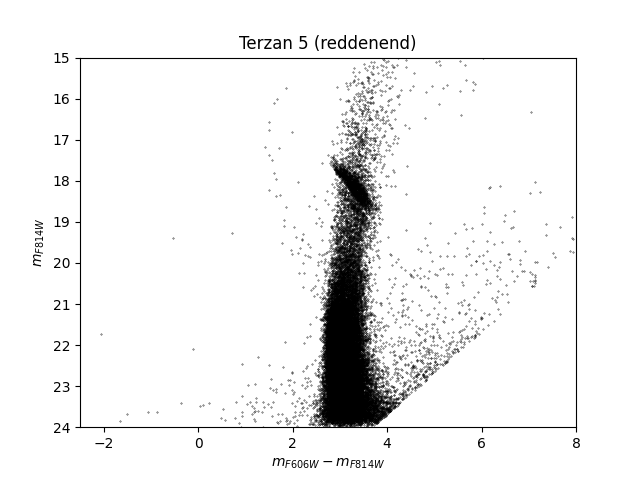

In [5]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Terzan 5 (reddenend)')
plt.show()

## Differential reddening correction
### Reddening Vector
Here we use the procedure and the values described in [Massari et. al 2012](https://iopscience.iop.org/article/10.1088/2041-8205/755/2/L32/pdf). 
We know that $R_I = A_I/E(B-V)$ and $R_V = A_V/E(B-V)$

The slope of the reddening vector is given by 
$$
\text{Slope} = \frac{R_I}{R_V-R_I}
$$

The slope indicates the direction and magnitude of the shift in the CMD due to the reddening. 

In [6]:
R_V = 2.83          # R_F606W
R_I = 1.82          # R_F814W

# plot the reddening vector
slope = (R_I)/(R_V-R_I)
E_BV = 0.2
delta_VI = (R_V-R_I)*E_BV
delta_I = R_I*E_BV

color_0 = 4
mag_0 = 20

color_1 = color_0 + delta_VI    
mag_1 = mag_0 + delta_I

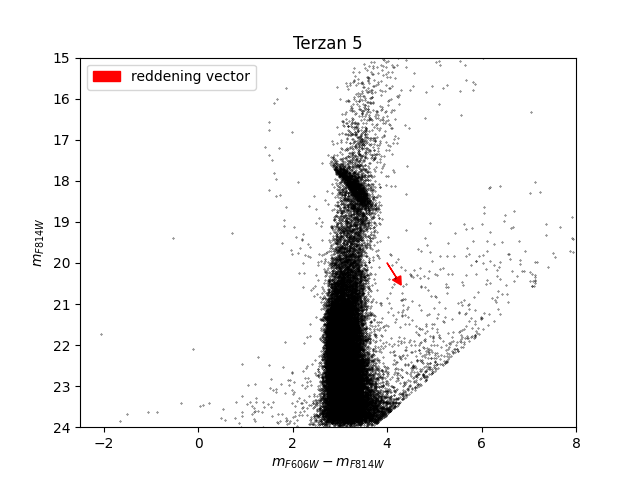

In [7]:
# plot reddening vector as an arrow
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.arrow(color_0, mag_0, color_1-color_0, mag_1-mag_0, head_width=0.2, head_length=0.2, fc='red', ec='red', label='reddening vector')
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('Terzan 5')
plt.show()

### Red Clump
Since Terzan 5 is in the direction of the Galactic Bulge, we can use the red clump to compute the differential reddening. In the CMD of this GC, however we have that the Red Clump may be mixed up with the RGB Bump in this CMD. Even though we can see the presence of the Red Clump just looking at the CMD we can try to plot an histogram to verify its presence. 

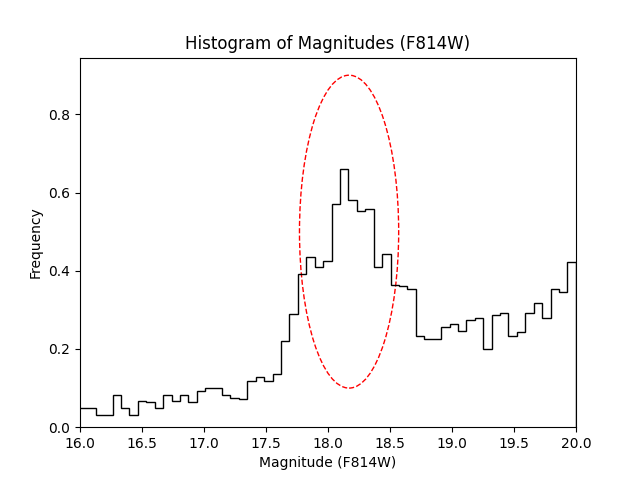

In [8]:
# Extract the F606W magnitudes
mag = np.where(data['F814W'] > 16, data['F814W'], np.nan)
magnitudes = np.where(data['F814W'] < 20, data['F814W'], np.nan)

# Create the histogram
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(magnitudes, bins=100, color='black', density=True, histtype='step')    

# Define the circle parameters
circle_radius = 0.4
circle_x = 18.17  # x-coordinate of the circle's center
circle_y = 0.5  # y-coordinate of the circle's center (height of the histogram bar)

# Create and add the circle
circle = plt.Circle((circle_x, circle_y), circle_radius, color='red', fill=False, linewidth=1, linestyle='dashed')
ax.add_patch(circle)

# Display the plot
plt.xlim(20, 16)
plt.gca().invert_xaxis()
plt.xlabel('Magnitude (F814W)')
plt.ylabel('Frequency')
plt.title('Histogram of Magnitudes (F814W)')
plt.show()

### Reddening correction
To correct for differential reddening we first divide the field of view in **sectors**.

In [9]:
n_sectors_x = 6  # Number of sectors along x
n_sectors_y = 6  # Number of sectors along y
x_bins = np.linspace(data['X'].min(), data['X'].max(), n_sectors_x+1)
y_bins = np.linspace(data['Y'].min(), data['Y'].max(), n_sectors_y+1)

# assign a sector to each data point
data['Sector'] = -1
sector_colors = []

for i in range(n_sectors_x):
    for j in range(n_sectors_y):
        sector_index = i * n_sectors_y + j
        sector_colors.append(sector_index)
        sector_data = (data['X'] >= x_bins[i]) & (data['X'] < x_bins[i+1]) & \
                      (data['Y'] >= y_bins[j]) & (data['Y'] < y_bins[j+1])
        data.loc[sector_data, 'Sector'] = sector_index

data.head()


,X,Y,F606W,F814W,Color,Magnitude,Sector
0,2630.52,3907.54,27.2402,22.3182,4.9220,22.3182,0
1,2652.88,3909.42,26.8100,23.6855,3.1245,23.6855,0
2,2600.77,3916.65,21.4564,18.1027,3.3537,18.1027,0
3,2983.68,3918.88,26.0843,23.2045,2.8798,23.2045,0
4,3014.33,3924.09,20.9049,17.8498,3.0551,17.8498,0


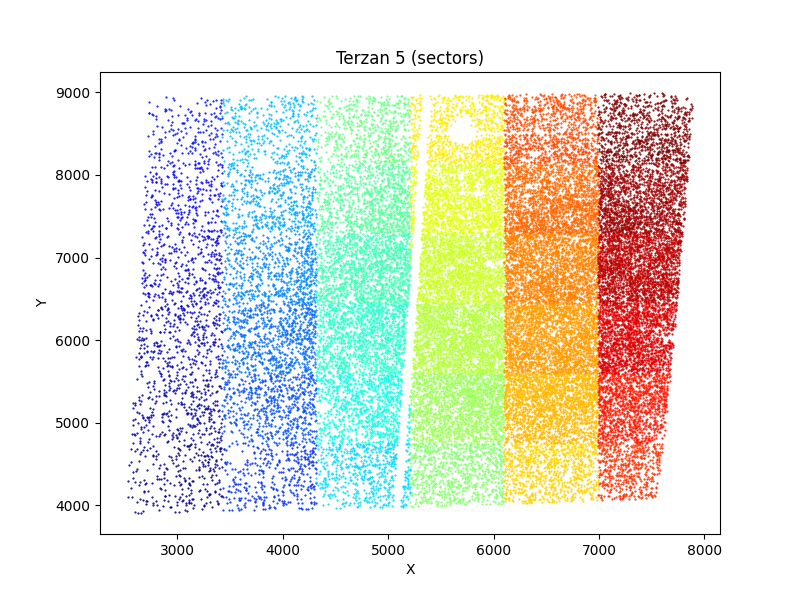

In [10]:
# plot the sensor sectors with different colors
plt.figure(figsize=(8, 6))
colors = plt.cm.jet(np.linspace(0, 1, n_sectors_x * n_sectors_y))

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['X'], sector_data['Y'], color=colors[sector_index], s=0.3, label=f'Sector {sector_index}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Terzan 5 (sectors)')
plt.show()

Now that the sensor is divided in sector we plot the CMD for each sector (in the same plot, the color of the CMD is the same as the sector in the sensor). The black dashed lines indicates approximately the position of the red clump. 

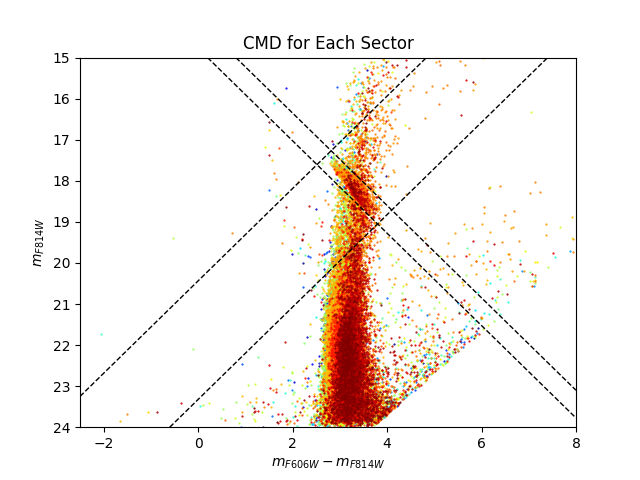

In [11]:
# plot the CMD for all sectors on the same figure
plt.figure()

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'], sector_data['F814W'], color=colors[sector_index], s=0.3)

# red clump region for Terzan 5
plt.axline((8.2, 24.), slope=1.125, color='black', linestyle='--', linewidth=1)
plt.axline((8.8, 24.), slope=1.125, color='black', linestyle='--', linewidth=1)
plt.axline((-0.6, 24.), slope=-1.125, color='black', linestyle='--', linewidth=1)
plt.axline((-0.5, 21), slope=-1.125, color='black', linestyle='--', linewidth=1)

slope = np.array([1.125, -1.125])
intercept = []
intercept.append(24 - slope[0]*8.2)
intercept.append(24 - slope[0]*8.8)
intercept.append(24 - slope[1]*(-0.6))
intercept.append(21 - slope[1]*(-0.5))
intercept = np.array(intercept)

plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('CMD for Each Sector')
plt.show()

Now for each sector we select the red clump stars (the ones inside the rectangle in the plot) and compute the mean point. At the end of this operation we'll have $N\times N$ points (where $N$ is the number of sectors along the $x$ an $y$ axis) representing the mean point of each red clump of each sector. 

In [12]:
# Select Red Clump (RC) stars
rc_data = data[ ( data['F814W'] <= slope[0]*(data['F606W'] - data['F814W']) + intercept[0])                      #above the left oblique line
            &   ( data['F814W'] >= slope[0]*(data['F606W'] - data['F814W']) + intercept[1])     
            &   ( data['F814W'] <= slope[1]*(data['F606W'] - data['F814W']) + intercept[2])    
            &   ( data['F814W'] >= slope[1]*(data['F606W'] - data['F814W']) + intercept[3])] 

# Calculate the mean point of RC stars for each sector
mean_points = []
color_excesses = []
mag_excesses = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_rc_data = rc_data[rc_data['Sector'] == sector_index]
    if not sector_rc_data.empty:
        mean_color = (sector_rc_data['F606W'] - sector_rc_data['F814W']).mean()
        mean_mag = sector_rc_data['F814W'].mean()
        mean_points.append((mean_color, mean_mag))
    else:
        mean_points.append((np.nan, np.nan))


Let's plot our CMD highlighting the stars of the red clump to check if our selection is reliable. 

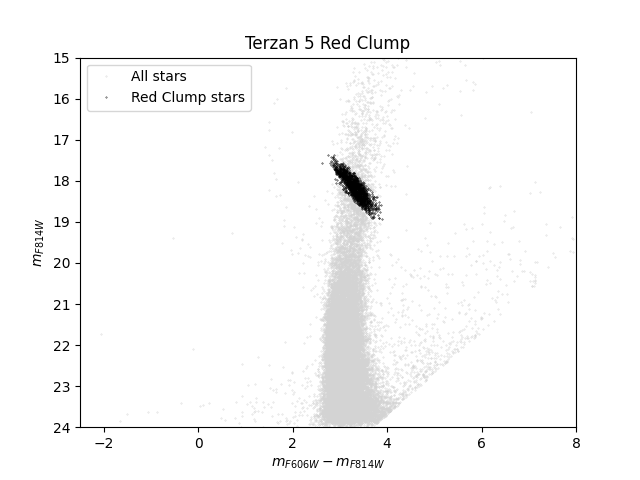

In [13]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='lightgrey', label='All stars')
plt.plot(rc_data['Color'], rc_data['Magnitude'], 'o', markersize=0.3, color='black', label='Red Clump stars')
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('Terzan 5 Red Clump')
plt.show()

Now we look for the sector with the lowest standard deviation and we take it as a reference sector (the position of the mean point is the best approximation of all the point, so this sector represent the one less affected by reddening). 

In [14]:
# compute the sector with the lowest standard deviation
stds = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_rc_data = rc_data[rc_data['Sector'] == sector_index]
    if not sector_rc_data.empty:
        std = (sector_rc_data['F606W']-sector_rc_data['F814W']).std()
        stds.append(std)
    else:
        stds.append(np.nan)

min_std_sector = np.nanargmin(stds)
print(f'Sector with the lowest standard deviation: {min_std_sector}')

Sector with the lowest standard deviation: 4


Now we compute, for each sector, the difference between its mean point and the mean point of the reference sector. This difference represent the **color excess** and the **magnitude excess**. 

Once we have done that we can plot the **corrected CMD** simply subtracting the color excess and the mag excess from the color index and the magnitude, respectively.

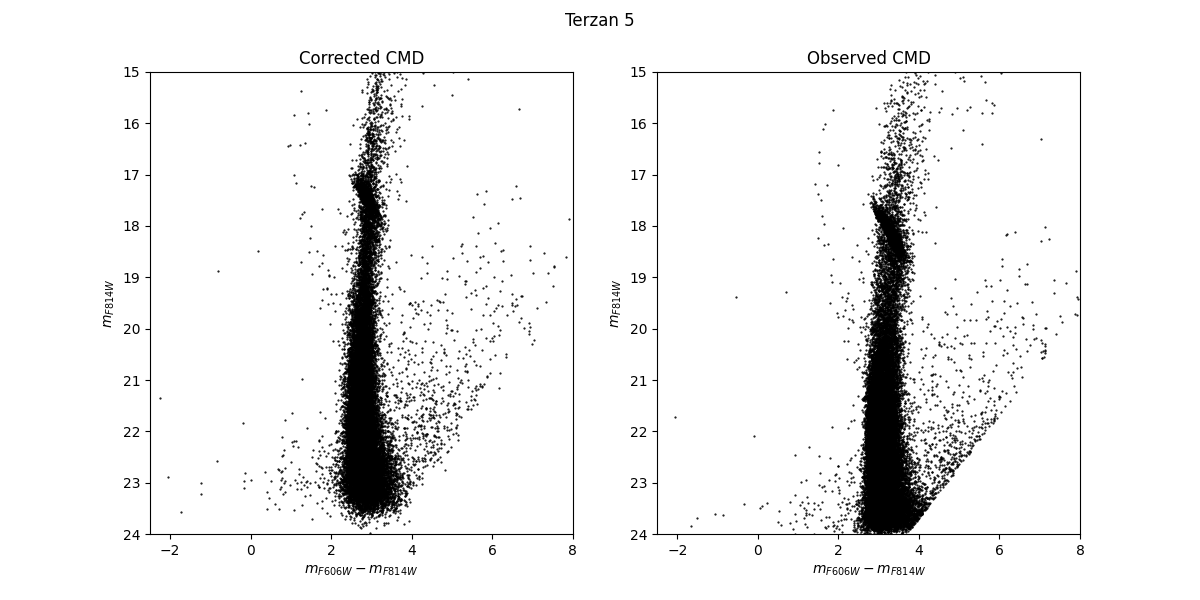

In [15]:
# compute for each sector the difference between the mean point and the minimum standard deviation sector
for sector_index in range(n_sectors_x * n_sectors_y): 
    color_excess = mean_points[sector_index][0] - mean_points[min_std_sector][0]
    mag_excess = mean_points[sector_index][1] - mean_points[min_std_sector][1]
    color_excesses.append(color_excess)
    mag_excesses.append(mag_excess)

# plot the CMD for all sectors on the same figure
plt.figure(figsize=(12,6))
plt.suptitle('Terzan 5')

plt.subplot(121)
for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color='black', s=0.3)
    
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Corrected CMD')

plt.subplot(122)
plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3)
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Observed CMD')

plt.show()


To see the difference between the corrected CMD and the original one we can plot them in the same figure. The black CMD is the original one, the colored one is the corrected.  

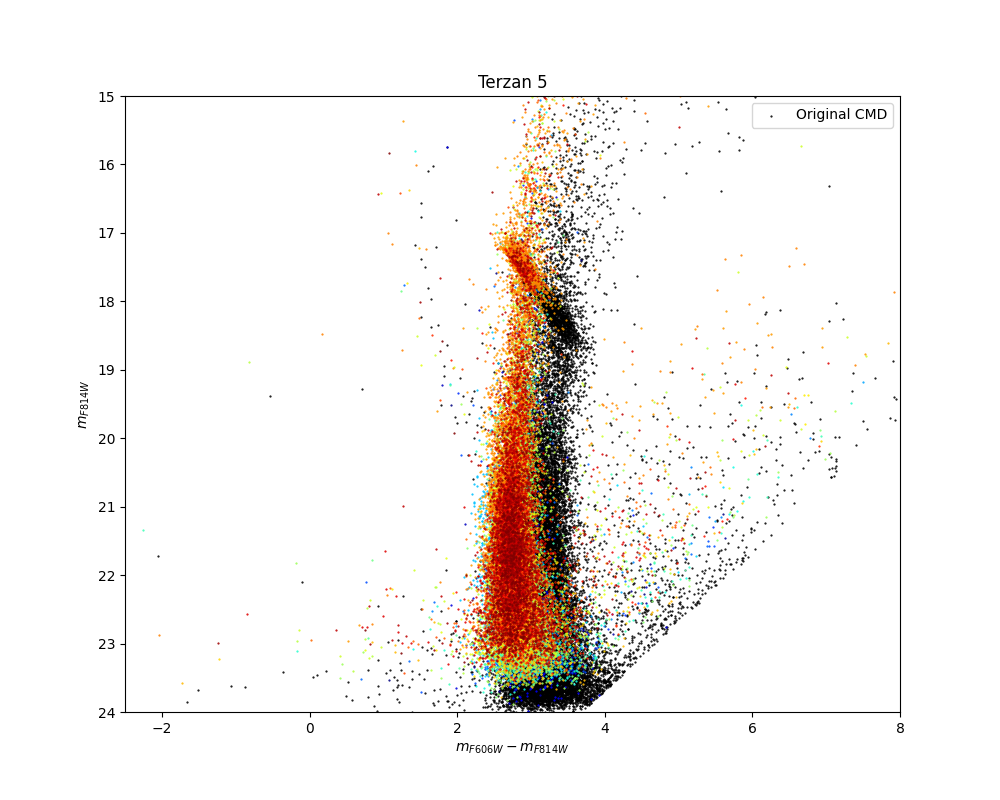

In [16]:
# compare the corrected CMD with the one affected by differential reddening on the same plot
plt.figure(figsize=(10, 8))

plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3, label='Original CMD')

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color=colors[sector_index], s=0.3)

plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend()
plt.title('Terzan 5')
plt.show()



## Final considerations
This method provides a good differential reddening correction, however takes a lot of computational time and needs some adjustments to be easily applicable to other CMDs since in our work we selected the red clump visually, using lines that are correct only for this specific case and we didn't apply any statistical tool. In addiciton, since this method completely relies on the presence of the Red Clump, it can be applyed only to young and metal rich populations since old clusters do not present the Red Clump.

In absence of the RC we have to use other methods, for example plotting fiducial lines for determined sequence and then correcting for differential reddening using these lines.

Moreover in this work we didn't consider the contamination of the field due to stars belonging to the galactic bulge so it is not a perfect correction.  

# Differential reddening correction for M22
M22 presents a CMD moderately affected by differential reddening, there is no need for proper motion correction since there is very small contamination. 

In [91]:
df_2 = pd.read_fwf('M22xymag.txt', delimiter='')

In [92]:
# add new column of ones as flag
flag = np.ones(len(df_2))
df_2['flag'] = flag

# change flag to 0 if F438W or F814W is saturated
df_2.loc[(df_2['F438W'] > 99) | (df_2['F814W'] > 99), 'flag'] = 0

# select flagged data
data_2 = df_2[df_2['flag' ] == 1.0]

# drop the comlumns we won't use
data_2 = data_2.drop(columns=['F275W', 'F336W', 'flag'])
data_2.head()

,X,Y,F438W,F814W
51,5014.9339,2728.0915,20.8330,18.4599
58,5004.3502,2738.0061,21.2302,18.8189
60,4840.0632,2738.7483,18.4868,16.6370
67,4871.0463,2744.5071,21.9568,19.3370
69,5118.3920,2746.8604,20.3204,18.2079


In [93]:
data_2.loc[:, 'Color'] = data_2['F438W'] - data_2['F814W']
data_2.loc[:, 'Magnitude'] = data_2['F814W']

data_2.head()

,X,Y,F438W,F814W,Color,Magnitude
51,5014.9339,2728.0915,20.8330,18.4599,2.3731,18.4599
58,5004.3502,2738.0061,21.2302,18.8189,2.4113,18.8189
60,4840.0632,2738.7483,18.4868,16.6370,1.8498,16.6370
67,4871.0463,2744.5071,21.9568,19.3370,2.6198,19.3370
69,5118.3920,2746.8604,20.3204,18.2079,2.1125,18.2079


Plot the CMD affected by reddening.

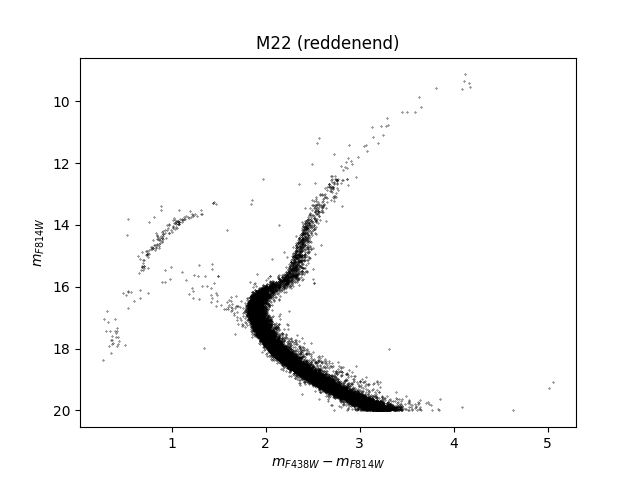

In [94]:
plt.figure()
plt.plot(data_2['Color'], data_2['Magnitude'], 'o', markersize=0.3, color='black')
plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('M22 (reddenend)')
plt.show()

Now we have to find the direction of the reddening so we need to plot the reddening vector. As we did before we have that the slope of the reddening vector is given by 
$$
\text{Slope} = \frac{R_{F814W}}{R_{F438W}-R_{F814W}}
$$
where $R_{F814W} = A_{F814W}/E/(B-V) = 1.86$ (I band) and $R_{F438W} = A_{F438W}/E/(B-V) = 4.18$ (B band). 

In [95]:
R_B = 4.18          # R_F438W     R_B
R_I = 1.86          # R_F814W     R_I

# plot the reddening vector
slope = (R_I)/(R_B-R_I)
E_BV = 0.2
delta_BI = (R_B-R_I)*E_BV
delta_I = R_I*E_BV

color_0 = 1.5
mag_0 = 17

color_1 = color_0 + delta_VI    
mag_1 = mag_0 + delta_I

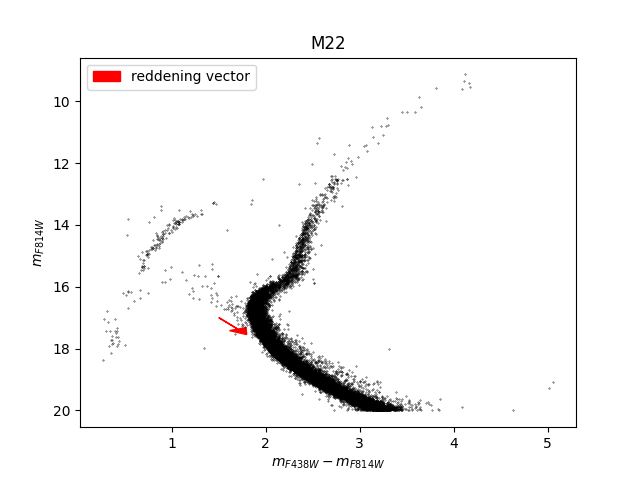

In [96]:
# plot reddening vector as an arrow
plt.figure()
plt.plot(data_2['Color'], data_2['Magnitude'], 'o', markersize=0.3, color='black')
plt.arrow(color_0, mag_0, color_1-color_0, mag_1-mag_0, head_width=0.2, head_length=0.2, fc='red', ec='red', label='reddening vector')
plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('M22')
plt.show()

Now we can rotate and translate the CMD in order to have the x-axis parallel to the reddening direction. We have to rotate the reference system of: 
$$
\theta = \arctan \frac{A_{F814W}}{A_{F438W}-A_{F814W}}
$$

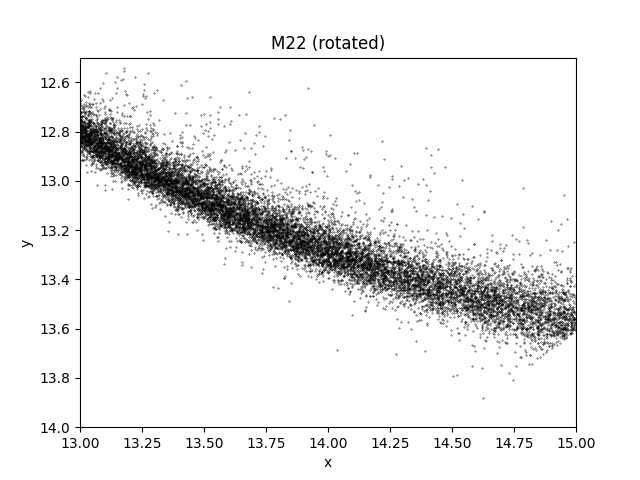

In [97]:
A_B = E_BV * R_B        # A_F438W
A_I = E_BV * R_I        # A_F814W

theta = np.arctan((A_I)/(A_B-A_I))

rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

# consider only the MS
data_MS = data_2[data_2['Magnitude'] > 18]

# rotate the data
data_MS.loc[:, ['Color', 'Magnitude']] = np.dot(data_MS.loc[:, ['Color', 'Magnitude']], rotation_matrix)

plt.figure()
plt.plot(data_MS['Color'], data_MS['Magnitude'], 'o', markersize=0.3, color='black')
plt.gca().invert_yaxis()
plt.xlim(13,15)
plt.ylim(14,12.5)
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title('M22 (rotated)')
plt.show()


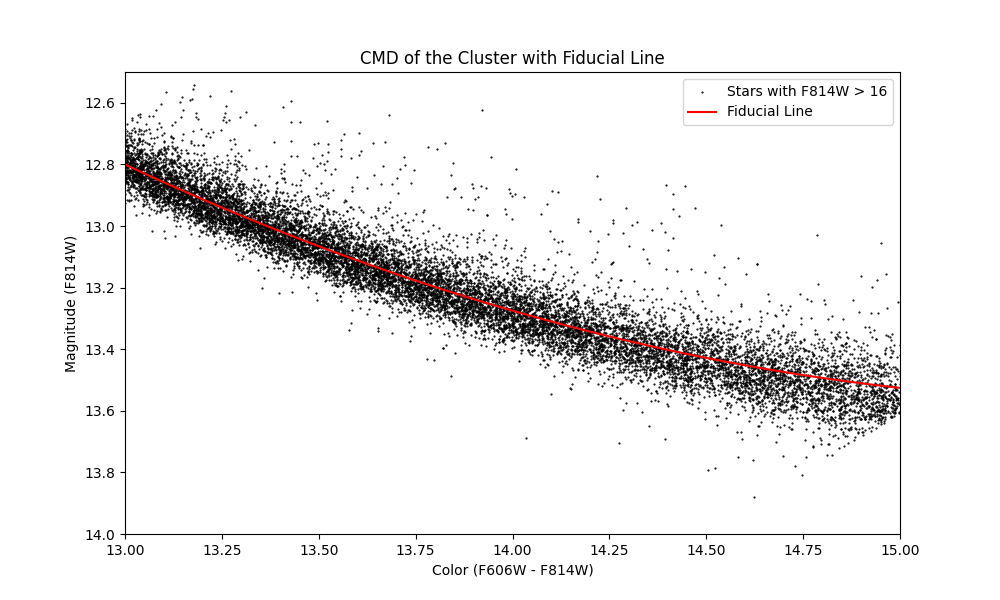

In [120]:
from numpy.polynomial.polynomial import Polynomial

# Fit a polynomial to the CMD data
degree = 2  # You can choose the degree of the polynomial
coefficients = Polynomial.fit(data_MS['Color'], data_MS['Magnitude'], degree).convert().coef

# Create a range of color values for plotting the fitted line
color_range = np.linspace(data_MS['Color'].min(), data_MS['Color'].max(), 500)
fiducial_line = np.polyval(coefficients[::-1], color_range)

# Plot the CMD and the fiducial line
plt.figure(figsize=(10, 6))
plt.scatter(data_MS['Color'], data_MS['Magnitude'], s=0.3, c='black', label='Stars with F814W > 16')
plt.plot(color_range, fiducial_line, c='red', label='Fiducial Line')
plt.gca().invert_yaxis()  # Invert y-axis for CMD
plt.xlim(13,15)
plt.ylim(14,12.5)
plt.xlabel('Color (F606W - F814W)')
plt.ylabel('Magnitude (F814W)')
plt.legend()
plt.title('CMD of the Cluster with Fiducial Line')
plt.show()
